## Load Model, plain 2D Conv

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/home/marvin/Projects/surface-rl-decoder'

In [2]:
import numpy as np
import torch
import json
from distributed.model_util import choose_model, choose_old_model, load_model, extend_model_config
from distributed.util import q_value_index_to_action
import matplotlib.pyplot as plt

In [3]:
model_name = "conv2d"
model_config_path = "src/config/model_spec/conv_agents_slim.json"
trained_model_path = "threshold_networks/5/72409/conv2d_5_72409.pt"

In [4]:
with open(model_config_path, "r") as jsonfile:
    model_config = json.load(jsonfile)[model_name]

code_size, stack_depth = 5, 5
syndrome_size = code_size + 1
model_config = extend_model_config(model_config, syndrome_size, stack_depth)
model_config["network_size"] = "slim"
model_config["rl_type"] = "q"

In [5]:
model = choose_model(model_name, model_config, transfer_learning=0)
model, *_ = load_model(model, trained_model_path, model_device="cpu")

Not using any recurrent module
Prepare Q Learning Conv2dAgent w/o transfer learning


In [ ]:
from evaluation.final_evaluation import main_evaluation

all_ground_states = 0
for i in range(10):
    is_ground_state, n_syndromes, n_loops = main_evaluation(
        model,
        model.device,
        epsilon=0.0,
        code_size=code_size,
        stack_depth=stack_depth,
        block=False,
        verbosity=0,
        rl_type=model_config["rl_type"]
    )
    
    all_ground_states += is_ground_state

print(all_ground_states)

In [7]:
print(all_ground_states)

10


## Prepare States

In [42]:
all_states = []

state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
state[-2:, 1, 2] = 1
all_states.append(state)


state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
state[-1, 1, 2] = 1
state[-1, 2, 3] = 1
all_states.append(state)

state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
state[-1, 2, 3] = 1
all_states.append(state)


state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
state[-2:, 1, 2] = 1
state[-2:, 2, 3] = 1
state[-1:, 2, 3] = 0
all_states.append(state)

state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
state[:, 1, 2] = 1
state[:, 2, 3] = 1
state[-1, 2, 3] = 0
all_states.append(state)

full_error_state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
full_error_state[:, 1, 2] = 1
full_error_state[:, 2, 3] = 1
all_states.append(full_error_state)

torch_all_states = torch.stack(all_states)

    
# for i in range(0, stack_depth, 2):
#     state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
#     state[:, 1, 2] = 1
#     state[:, 2, 3] = 1
#     state[i, 2, 3] = 0
    
#     all_states.append(state)

# for i in range(0, stack_depth, 2):
#     state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
#     state[i, 2, 3] = 1
    
#     all_states.append(state)

# state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
# state[-1, 1, 2] = 1
# state[-1, 2, 3] = 1
# all_states.append(state)

# state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
# state[-2:, 1, 2] = 1
# state[-2:, 2, 3] = 1
# state[-1:, 2, 3] = 0
# all_states.append(state)

# state = torch.zeros((stack_depth, syndrome_size, syndrome_size), dtype=torch.float32)
# state[-2:, 1, 2] = 1
# all_states.append(state)

# torch_all_states = torch.stack(all_states)

In [43]:
def calculate_state_image(state, stack_depth, syndrome_size):
    layer_discount_factor = 0.3
    layer_exponents = np.arange(stack_depth - 1, -1, -1)
    layer_rewards = np.power(layer_discount_factor, layer_exponents)
    layer_rewards = torch.tensor(layer_rewards, dtype=torch.float32)

    state_image = torch.zeros((syndrome_size, syndrome_size), dtype=torch.float32)
    for j, layer in enumerate(state):
        tmp_layer = layer * layer_rewards[j]
        state_image += tmp_layer

    return state_image

## Do the plotting

ind=array([17, 18, 19])
ind=array([32, 33, 34])
ind=array([74, 75, 75])
ind=array([32, 33, 34])
ind=array([32, 33, 34])
ind=array([32, 33, 34])
['(1, 2)', '(1, 2)', '(1, 2)', '(1, 2)', '(1, 2)', '(1, 2)', '(2, 3)', '(2, 3)', '(2, 3)', '(2, 3)', '(2, 3)', '(2, 3)']


<ipython-input-93-db1bf4698cfa>:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_tick_labels)


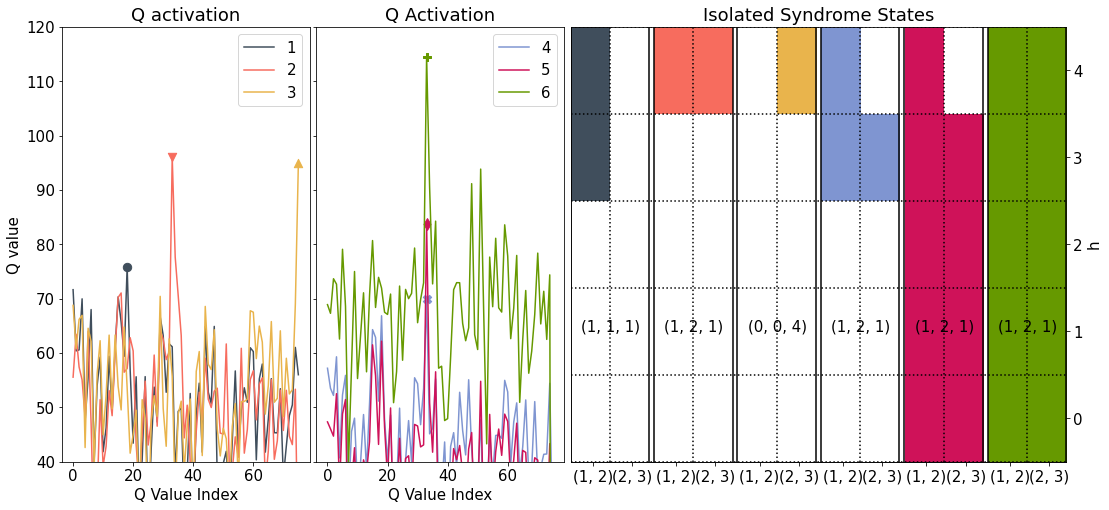

In [93]:
k = 1
# stack_depth = 5
# syndrome_size = 5
from matplotlib import colors
plt.rcParams.update({"font.size": 15})


fig, ax = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={"width_ratios": [4, 4, 8], "wspace": 0.02, "hspace": 0.0},)
plot_colors = ["#ffffff", "#404E5C", "#F76C5E", "#E9B44C", "#7F95D1", "#CF1259", "#669900"]
markers = ["o", "v", "^", "X", "d", "P"]
cmap = colors.ListedColormap(plot_colors)
boundaries = range(len(torch_all_states))
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

markersize = 70
img_separation = 1
column_width = 8
syndrome_locations = np.array([[1, 2],[2, 3]])
column_filler = np.zeros((stack_depth, 1))
image_filler = np.zeros((stack_depth, img_separation))
img_width = 2 * column_width + img_separation

vline_locations = np.array([
    column_width + i * img_width for i in range(len(torch_all_states))
])
image_separators_left = np.array([
    (i+1) * 2 * column_width + i * img_separation for i in range(len(torch_all_states))
])
# image_separators_left[1:] += img_separation

image_separators_right = [
    i * img_width for i in range(len(torch_all_states))
]
hline_locations = range(0, stack_depth + 1)

complete_image_list = []

for i, state in enumerate(torch_all_states):
    ii = i + 1
    # TODO: concat the columns multi-pixel wide with an empty space in between
    # and empty spaces between each state's column
    column1 = np.vstack(state[:, syndrome_locations[0, 0], syndrome_locations[0, 1]])
    repeated_column1 = np.repeat(column1, column_width, axis=1)
    
    column2 = np.vstack(state[:, syndrome_locations[1, 0], syndrome_locations[1, 1]])
    repeated_column2 = np.repeat(column2, column_width, axis=1)
    
    state_img = np.concatenate((repeated_column1, repeated_column2), axis=1) * ii

    complete_image_list.append(state_img)
    if i < len(torch_all_states) - 1:
        complete_image_list.append(image_filler)
        
complete_image_array = np.concatenate(complete_image_list, axis=1)

ax2 = ax[2].twinx()
for i, state in enumerate(torch_all_states):
    ii = i + 1
    q_values = model(state.unsqueeze(0))
    q_values = q_values.detach().squeeze().clone().numpy()
    
    ind = np.argpartition(q_values, -k)[-k:]
    max_ind = ind
    action = q_value_index_to_action(ind[0], code_size)
    ind = np.append(ind, [max(ind[0]-1, 0), min(ind[0]+1, len(q_values)-1)])
    ind = np.sort(ind)
    print(f"{ind=}")
    
    q_hist = np.histogram(q_values)
    
    if i < 3:
        ax[0].plot(range(len(q_values)), q_values, label=str(ii), color=plot_colors[ii])
        ax[0].scatter(
            max_ind, q_values[max_ind], marker=markers[i], c=plot_colors[ii], s=markersize
        )
#         marker=markers[i], c=plot_colors[ii]
    else:
        ax[1].plot(range(len(q_values)), q_values, label=str(ii), color=plot_colors[ii]),
        ax[1].scatter(
            max_ind, q_values[max_ind], marker=markers[i], c=plot_colors[ii], s=markersize
        )
    ax2.imshow(
        complete_image_array, vmin=0, vmax=6, cmap=cmap, aspect='auto', origin='lower'
    )
    ax2.axvline(x=vline_locations[i] - 0.5, linestyle=':', color='black')
    ax2.axhline(y=hline_locations[i] - 0.5, linestyle=':', color='black')
    
    ax2.axvline(x=image_separators_left[i] - 0.5, color='black')
    ax2.axvline(x=image_separators_right[i] - 0.5, color='black')
    
    ax2.text(x=image_separators_left[i] - 1.8 * column_width, y=1, s=f"{action}")
    


ax[0].set(
    ylim=(40, 120), 
    xlabel="Q Value Index",
    ylabel="Q value", 
    title=f"Q activation", 
)
ax[1].set(
    ylim=(40, 120), 
    xlabel="Q Value Index",
    title=f"Q Activation", 
)

all_vline_locations = np.concatenate(
    [vline_locations - 0.5 * column_width, vline_locations + 0.5 * column_width]
)

x_tick_labels = [f"{tuple(syndrome_locations[0])}"] * len(torch_all_states)
x_tick_labels2 = [f"{tuple(syndrome_locations[1])}"] * len(torch_all_states)
x_tick_labels.extend(x_tick_labels2)
# , f"{tuple(syndrome_locations[1])}"] * len(torch_all_states)
print(f"{x_tick_labels}")

ax2.set(xlabel="", ylabel="h", title="Isolated Syndrome States")
ax[2].set_yticks(all_vline_locations)
ax[2].set_yticks([])
ax[2].set_yticklabels([])
ax2.set_xticklabels(x_tick_labels)
ax2.set_xticks(all_vline_locations)

ax[1].set_yticklabels([])
    
ax[0].legend()
ax[1].legend()

plt.savefig("plots/q_value_activation.pdf", bbox_inches="tight")

## 3D Conv

In [1]:
model_name = "conv3d"
model_config_path_3d = "src/config/model_spec/conv_agents_slim.json"
trained_model_path_3d = "threshold_networks/5/69312/conv3d_5_69312.pt"

In [2]:
with open(model_config_path_3d, "r") as jsonfile:
    model_config_3d = json.load(jsonfile)[model_name]

code_size, stack_depth = 5, 5
syndrome_size = code_size + 1
model_config_3d = extend_model_config(model_config_3d, syndrome_size, stack_depth)
model_config_3d["network_size"] = "slim"
model_config_3d["rl_type"] = "q"

NameError: name 'json' is not defined

In [10]:
model3d = choose_old_model(model_name, model_config_3d)
model3d, *_ = load_model(model3d, trained_model_path_3d, model_device="cpu")

In [ ]:
from evaluation.final_evaluation import main_evaluation

all_ground_states = 0
for i in range(10):
    is_ground_state, n_syndromes, n_loops = main_evaluation(
        model3d,
        model3d.device,
        epsilon=0.0,
        code_size=code_size,
        stack_depth=stack_depth,
        block=False,
        verbosity=0,
        rl_type=model_config_3d["rl_type"]
    )
    
    all_ground_states += is_ground_state

print(all_ground_states)

In [18]:
print(all_ground_states)

10


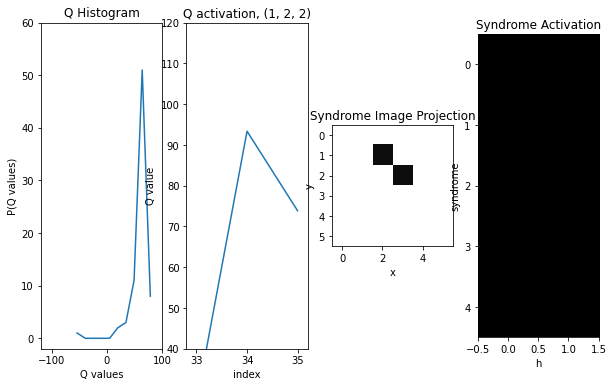

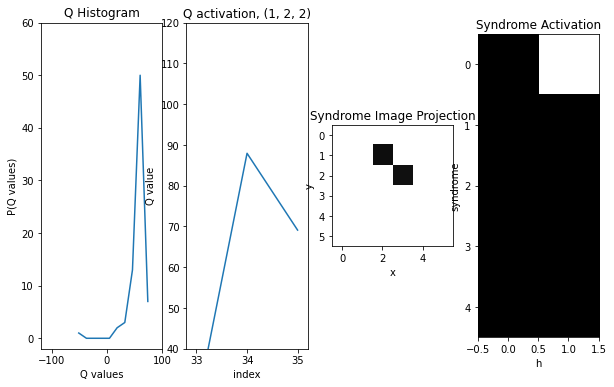

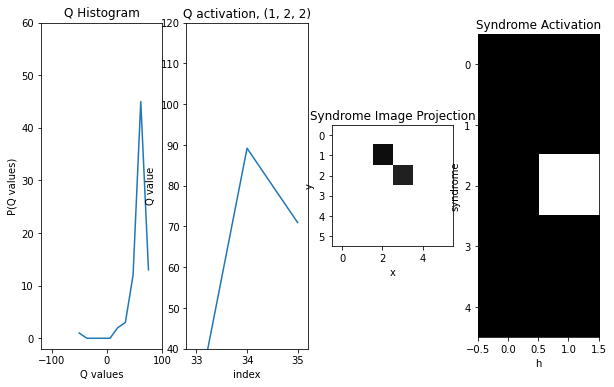

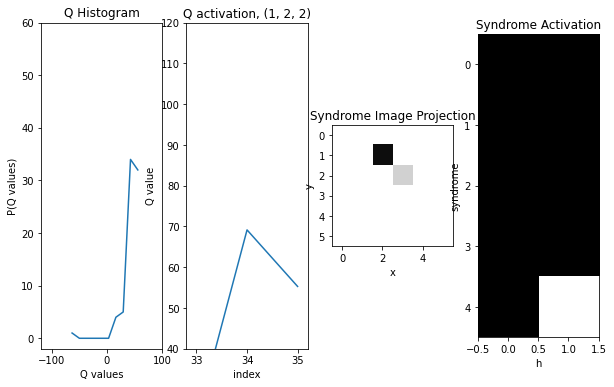

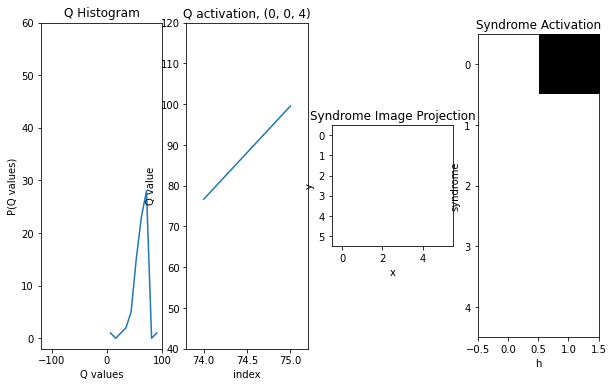

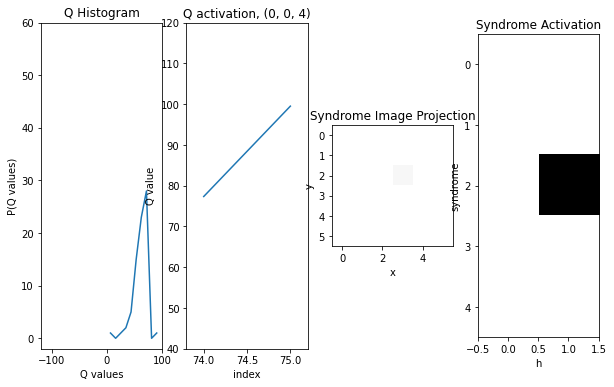

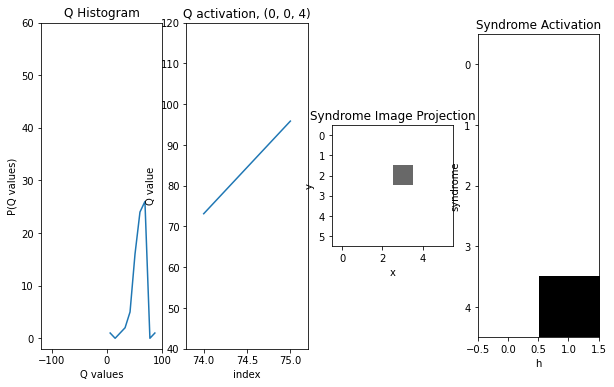

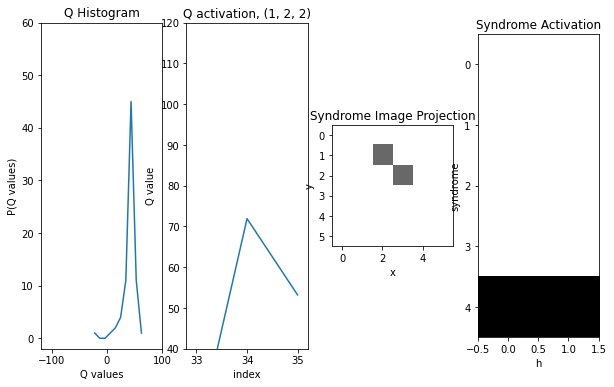

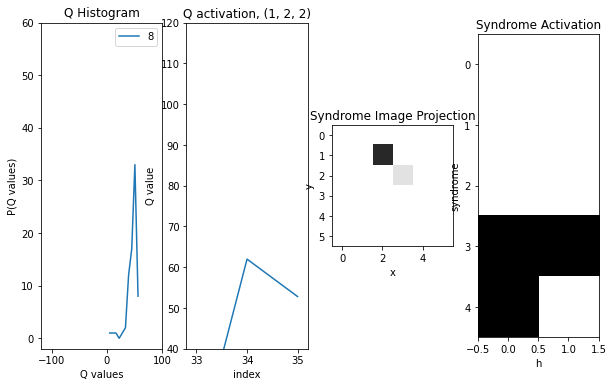

In [11]:
k = 1
# stack_depth = 5
# syndrome_size = 5


for i, state in enumerate(torch_all_states):
    fig, ax = plt.subplots(1, 4, figsize=(10, 6))
    q_values = model3d(state.unsqueeze(0))
    q_values = q_values[0].detach().squeeze().clone().numpy()
    
    ind = np.argpartition(q_values, -k)[-k:]
    action = q_value_index_to_action(ind[0], code_size)
    
    ind = np.append(ind, [max(ind[0]-1, 0), min(ind[0]+1, len(q_values)-1)])
    ind = np.sort(ind)
    
    q_hist = np.histogram(q_values)
    
    
    ax[0].plot(q_hist[1][:-1], q_hist[0], label=str(i))
    
#     ax[1].plot(ind, q_values[ind], label=str(i))
    ax[1].plot(range(len(q_values)), q_values, label=str(i))
    
    state_image = calculate_state_image(state, stack_depth, syndrome_size)
    ax[2].imshow(state_image, vmin=0, vmax=1.5, cmap="Greys")
    
    ax[3].imshow(
        np.hstack(
            (
                np.vstack(state[:, 1, 2]),
                np.vstack(state[:, 2, 3]),
            )
        ),
        vmin=0, vmax=1, cmap="Greys"
    )
    
    ax[0].set(ylim=(-2, 60), xlim=(-120, 100), xlabel="Q values", ylabel="P(Q values)", title=f"Q Histogram")
    ax[1].set(ylim=(40, 120), xlabel="index", ylabel="Q value", title=f"Q activation, {action}", xlim=[max(ind[0], 0)-0.2, min(ind[-1], len(q_values)-1)+0.2])
    ax[2].set(xlabel="x", ylabel="y", title="Syndrome Image Projection")
    ax[3].set(xlabel="h", ylabel="syndrome", title="Syndrome Activation")
    
ax[0].legend()
# ax[1].legend()
    
    

In [12]:
from distributed.util import select_actions

In [13]:
from surface_rl_decoder.surface_code import SurfaceCode
from surface_rl_decoder.surface_code_util import create_syndrome_output_stack

In [14]:
# q_values = model3d(full_error_state)
action, _ = select_actions(full_error_state.unsqueeze(0), model3d, code_size)

In [19]:
sc = SurfaceCode(code_size=code_size, stack_depth=stack_depth)
sc.qubits[:, 1, 2] = 1
sc.state = create_syndrome_output_stack(
    sc.qubits, sc.vertex_mask, sc.plaquette_mask
)
np.argwhere(sc.state)

array([[0, 1, 2],
       [0, 2, 3],
       [1, 1, 2],
       [1, 2, 3],
       [2, 1, 2],
       [2, 2, 3],
       [3, 1, 2],
       [3, 2, 3],
       [4, 1, 2],
       [4, 2, 3]])

In [20]:
from copy import deepcopy
torch_state = torch.tensor(deepcopy(sc.state), dtype=torch.float32)
action, _ = select_actions(torch_state.unsqueeze(0), model3d, code_size)
action

array([[1, 2, 2]])

In [21]:
new_state, *_ = sc.step(action[0])

In [22]:
torch_state = torch.tensor(deepcopy(sc.state), dtype=torch.float32)
action, _ = select_actions(torch_state.unsqueeze(0), model3d, code_size)
action

array([[1, 2, 3]])

In [23]:
new_state, *_ = sc.step(action[0])

In [24]:
new_state

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]])